The MAGIC (**M**isclassification **A**nalysis by **G**raphic **I**nduction-Tree **C**lassifier) tool utilizes the explainable and graphical characteristics of a tree for misclassification analysis.

The tool is useful for cases in which:
* Samples of two different classes reside in proximity to each other so their boundaries are blurred or overlap.
* The misclassified samples belong to a subclass with hidden characteristics (known as Hidden Stratification).
* Samples with the same or almost similar attributes are labeled differently.

In this notebook I will present the tool's capabilities by examining the classification results for samples that answer (or do not answer) the following closed formula: $a \cap b \cup c$ (the formula will simulate some unknown classifier).

At the end of the notebook, I'll briefly demonstrate the tool's capabilities using a real-world example.

# Train-Set Creation

First, we'll create a train-set that represents the above formula completely:

In [ ]:
func = lambda row: row[0] & row[1] | row[2]

In [ ]:
import pandas as pd
import numpy as np

a = [0] * 4 + [1] * 4
b = (([0] * 2) + [1] * 2) * 2
c = [0,1] * 4

X_train = pd.DataFrame(np.array([a,b,c]).T, columns = ['a', 'b', 'c'])
y_train = X_train.apply(func, axis = 1).rename('class')

print("The train set is:")
pd.concat([X_train, y_train], axis = 1)



The train set is:


,a,b,c,class
0,0,0,0,0
1,0,0,1,1
2,0,1,0,0
3,0,1,1,1
4,1,0,0,0
5,1,0,1,1
6,1,1,0,1
7,1,1,1,1


# Test-Set Creation

Now we create a test-set with artificially generated class labels:

In [ ]:
X_test = pd.DataFrame([[1,1,0],[1,0,1],[1,1,1],[0,0,0],[0,1,1],[1,0,0]], columns = ['a','b','c'])
y_test = pd.Series([1, 0, 0, 0, 1, 1], name = 'class') 

test_set = pd.concat([X_test, y_test], axis = 1)
test_set

,a,b,c,class
0,1,1,0,1
1,1,0,1,0
2,1,1,1,0
3,0,0,0,0
4,0,1,1,1
5,1,0,0,1


We can see than only samples with index 0, 3, and 4 fit the formula while the others (1, 2 and 5) do not:

In [ ]:
classificaion_result = X_test.apply(func, axis = 1).rename('predicted_class')
correctly_classified = (classificaion_result == y_test).rename('correctly_classified?')
pd.concat([X_test, y_test.rename('Expected_class'), classificaion_result, correctly_classified], axis = 1)

,a,b,c,Expected_class,predicted_class,correctly_classified?
0,1,1,0,1,1,True
1,1,0,1,0,1,False
2,1,1,1,0,1,False
3,0,0,0,0,0,True
4,0,1,1,1,1,True
5,1,0,0,1,0,False


So, we can see that we have 2 cases:
* **1 misclassified as 0:** One sample (5) for which we excpected to get 1 but it was misclassified as 0.
* **0 misclassified as 1:** Two samples (1+2) for which we excpected to get 0 but they were misclassified as 1.

It is important to note that in both cases it is not the classifier's fault as it was trained on different data.

# Illustrating Misclassifications Using The MAGIC Tool

First, We will load the MAGIC tool by pressing the following button:

In [ ]:
#@title Press the run button to load the MAGIC tool

import numpy as np
import graphviz
import matplotlib.colors as mc
import re
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from PIL import Image

import warnings # Suppress warning for this notebook
warnings.filterwarnings("ignore")

PRESENT_ALL = 'all'
PRESENT_VISITED = 'visited'
PRESENT_MISCLASSIFIED = 'misclassified'

##################
## Graphvitz utils

replace_words = ['<thead>', '<tbody>', '</thead>', '</tbody>', '\n', '\rn', '<table border="1" class="dataframe">',
                 '</table>']
pattern = '|'.join(replace_words)

def dataframe_to_graphviz_table(df):
    '''
    Translates a html table to graphviz format
    references:
    https://renenyffenegger.ch/notes/tools/Graphviz/attributes/label/HTML-like/index
    https://graphviz.org/Gallery/gradient/table.html
    '''
    html_table = df.to_html()
    return re.sub(pattern, '', html_table).replace('th', 'td').replace('<td>', '<td border="1" bgcolor = "white">')

def to_graphviz_format(node_header, cm):
    cm_table = dataframe_to_graphviz_table(cm)
    return '<<table border = "0">' \
           '<tr><td border = "0" colspan="3"><b>%s</b></td></tr>' \
            '%s' \
           '</table>>' % (node_header, cm_table)

####################
def create_legend (expected_label, predicted_label, expected_label_color, predicted_label_color):
    elc = color_to_hex(expected_label_color)
    plc = color_to_hex(predicted_label_color)
    return f'<<table border = "0">' \
           f'<tr><td border = "1" bgcolor= "{elc}"> expected label </td> \
                <td border = "1" bgcolor= "{plc}"> predicted label </td></tr>' \
           f'<tr><td border = "1" bgcolor= "{elc}"> {expected_label} </td> \
                <td border = "1" bgcolor= "{plc}"> {predicted_label} </td></tr>' \
           f'</table>>'

def create_cm_for_node(tp, fp, tn, fn, true_label, false_label):
    if tp == 0 and fp == 0 and tn == 0 and fn == 0:
        return None
    else:
        return pd.DataFrame({false_label: [tn, fn], true_label: [fp, tp]}, index = [false_label,true_label])

def get_nodes_visits_count_list(n_nodes, node_indicator, samples_ids):
    visits_count = [0] * n_nodes
    for sample_id in samples_ids:
        # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
        node_indexes = node_indicator.indices[
                     node_indicator.indptr[sample_id]: node_indicator.indptr[sample_id + 1]
                     ]
        for node_index in node_indexes:
            visits_count[node_index] += 1
    return visits_count

def color_to_hex(color):
    try:
        color = mc.cnames[color]
    except:
        pass
    return color

def merge_color(first_color, first_color_quantity, second_color, second_color_quantity):
    if first_color_quantity == 0 and second_color_quantity == 0:
        return 'white'
    else:
        fc = color_to_hex(first_color)
        sc = color_to_hex(second_color)
        fc_rgb = tuple(int(fc.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        sc_rgb = tuple(int(sc.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        total = first_color_quantity + second_color_quantity
        adjusted_r = round((first_color_quantity * fc_rgb[0] + second_color_quantity * sc_rgb[0]) / total)
        adjusted_g = round((first_color_quantity * fc_rgb[1] + second_color_quantity * sc_rgb[1]) / total)
        adjusted_b = round((first_color_quantity * fc_rgb[2] + second_color_quantity * sc_rgb[2]) / total)
        return '#%02x%02x%02x' % (adjusted_r, adjusted_g, adjusted_b)

def plot_misclassification_in_tree(clf, X, y, expected_label, predicted_label, expected_label_color, predicted_label_color,
                                   show_cm = True, present = PRESENT_ALL):
    y = np.array(y)  # Will be easier if y is guaranteed to be of type np array
    v = graphviz.Digraph()

    v.node(str(-1), create_legend(expected_label, predicted_label, expected_label_color, predicted_label_color),
           {'shape': 'component', 'style': 'filled', 'fillcolor': 'white'})

    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    classification = clf.predict(X)
    node_indicator = clf.decision_path(X)

    # Step 1: check how the true data traverse along the classifier
    expected_label_labeled_samples_ids = [i for i in range(len(X)) if y[i] == expected_label]
    predicted_label_labeled_samples_ids = [i for i in range(len(X)) if y[i] == predicted_label]

    expected_label_labeled_visit_count = get_nodes_visits_count_list(n_nodes, node_indicator, expected_label_labeled_samples_ids)
    predicted_label_labeled_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, predicted_label_labeled_samples_ids)

    # Step 2: inspect how the classifier would classify the samples - and create a confusion marix for it.
    true_positive_samples_ids = [i for i in range(len(X)) if
                                 y[i] == expected_label and classification[i] == expected_label]
    false_positive_samples_ids = [i for i in range(len(X)) if
                                  y[i] == predicted_label and classification[i] == expected_label]
    true_negative_samples_ids = [i for i in range(len(X)) if
                                 y[i] == predicted_label and classification[i] == predicted_label]
    false_negative_samples_ids = [i for i in range(len(X)) if
                                  y[i] == expected_label and classification[i] == predicted_label]

    tp_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, true_positive_samples_ids)
    fp_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, false_positive_samples_ids)
    tn_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, true_negative_samples_ids)
    fn_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, false_negative_samples_ids)

    if PRESENT_ALL == present:
        nodes_ids_to_plot = range(n_nodes)
    elif PRESENT_VISITED == present:
        total_visits_count = [sum(x) for x in zip(tp_visits_count, fp_visits_count, tn_visits_count, fn_visits_count)]
        nodes_ids_to_plot = [i for i in range(len(total_visits_count)) if total_visits_count[i] > 0]
    elif PRESENT_MISCLASSIFIED == present:
        nodes_ids_to_plot = [i for i in range(len(fn_visits_count)) if fn_visits_count[i] > 0]
    else:
        raise Exception('Uknown present value: %s' % present)

    for i in nodes_ids_to_plot:
        node_id = str(i)

        if children_left[i] == children_right[i]: # this is a leaf
            label = str(clf.classes_[np.argmax(clf.tree_.value[i])])
            if show_cm:
                cm = create_cm_for_node(tp_visits_count[i], fp_visits_count[i], tn_visits_count[i], fn_visits_count[i], expected_label, predicted_label)
                if cm is None:
                    node_content = label
                else:
                    node_content = to_graphviz_format(label, cm)
            else:
                node_content = label
            peripheries = '2' if fn_visits_count[i] > 0 else '1'
            fill_color = merge_color(expected_label_color, expected_label_labeled_visit_count[i], predicted_label_color, predicted_label_labeled_visits_count[i])
            v.node(node_id, node_content, {'shape': 'rect', 'style': 'filled', 'fillcolor': fill_color, 'peripheries': peripheries})

        else: # this is a split node
            node_feature = X.columns[feature[i]]
            node_tresshold = threshold[i]

            label = str(node_feature)
            if show_cm:
                cm = create_cm_for_node(tp_visits_count[i], fp_visits_count[i], tn_visits_count[i], fn_visits_count[i], expected_label, predicted_label)
                if cm is None:
                    node_content = label
                else:
                    node_content = to_graphviz_format(label, cm)
            else:
                node_content = label

            fill_color = merge_color(expected_label_color, expected_label_labeled_visit_count[i], predicted_label_color, predicted_label_labeled_visits_count[i])
            peripheries = '2' if fn_visits_count[i] > 0 else '1'
            v.node(node_id, node_content, {'shape': 'rect', 'style': 'filled', 'fillcolor': fill_color, 'peripheries': peripheries})

            if children_left[i] in nodes_ids_to_plot:
                v.edge(node_id, str(children_left[i]), node_feature + "<=" + str(round(node_tresshold, 5)))
            if children_right[i] in nodes_ids_to_plot:
                v.edge(node_id, str(children_right[i]), node_feature + ">" + str(round(node_tresshold, 5)))

    v.node(str(n_nodes), f'Total misclassification: {len(false_negative_samples_ids)}/{len(X)}',  {'shape': 'underline'}) # TODO replace with existing conut
    # v.render(directory='doctest-output', view=True, format='jpeg')
    output_path = v.render(format = 'jpg')
    im = Image.open(output_path) 
      
    # resize the image for better presentation 
    width, height = int(im.width / im.height * 600), 600
    im_resized = im.resize((width, height))
    return clf, im_resized

def plot_misclassification(X_train, y_train, X_test, y_test, expected_label, predicted_label, expected_label_color, predicted_label_color,
                           show_cm = True, present = PRESENT_ALL, max_depth = None):
    # Note: setting random_state to a constant number for deterministic tree creation. See: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    clf = DecisionTreeClassifier(random_state=42) if max_depth is None else  DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    return plot_misclassification_in_tree(clf, X_test, y_test, expected_label, predicted_label, expected_label_color, predicted_label_color, show_cm, present)


def extract_decision_predicate_by_path(clf, X):
    X_test = X.to_numpy()

    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    node_indicator = clf.decision_path(X_test)
    leaf_id = clf.apply(X_test)
    samples_rules_dict = {}

    for sample_id in range(len(X)):
        rules = []
        # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
        node_index = node_indicator.indices[
                     node_indicator.indptr[sample_id]: node_indicator.indptr[sample_id + 1]
                     ]

        for node_id in node_index:
            # continue to the next node if it is a leaf node
            if leaf_id[sample_id] == node_id:
                continue

            # check if value of the split feature for sample 0 is below threshold
            if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
                threshold_sign = "<="
            else:
                threshold_sign = ">"

            rules.append(f'(x[\'{X.columns[feature[node_id]]}\'] {threshold_sign} {threshold[node_id]})')

        samples_rules_dict[X.index[sample_id]] = " & ".join(rules)
    return samples_rules_dict


## Case A: 1 Misclassified as 0

Let see how the MAGIC tool can illustrate how the data behaved in this case.

For that we have several options:

### Using The MAGIC Tool With Default Values

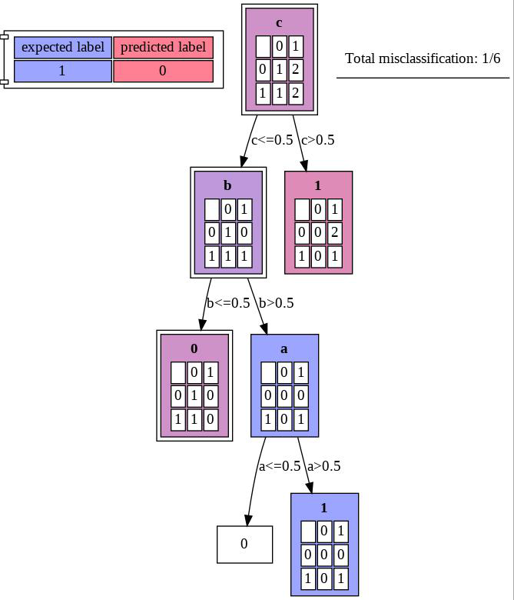

In [ ]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label = 1, predicted_label = 0, 
                                   expected_label_color = '#9ca5ff', predicted_label_color = '#ff8093',
                                   show_cm = True, present = 'all', max_depth = None)
plot

The above illustrates how the test-data is distributed along the tree:

* Nodes to which mostly 0-labeled samples reached are colored with a pinkish shades. 
* Nodes to which mostly 1-labeld samples reached are colored with blue shades.

In each node, a confusion matrix illustrates the distribution of the samples' prediction that passed through it.

Nodes that weren't reached by any sample of the test-set do not have a confusion matrix and are colored with white.

Nodes to which misclassied data that answer the requirements reached, are marked with a double frame.

Pay attention to the legends that assist in the readability of the tree.

### The `present` Attribute

We can use the `present` attribute different options to present only nodes that were relevant for the test-set samples, i.e. remove nodes that weren't reached. 

This is done by setting the `present` attribute to `visited`:

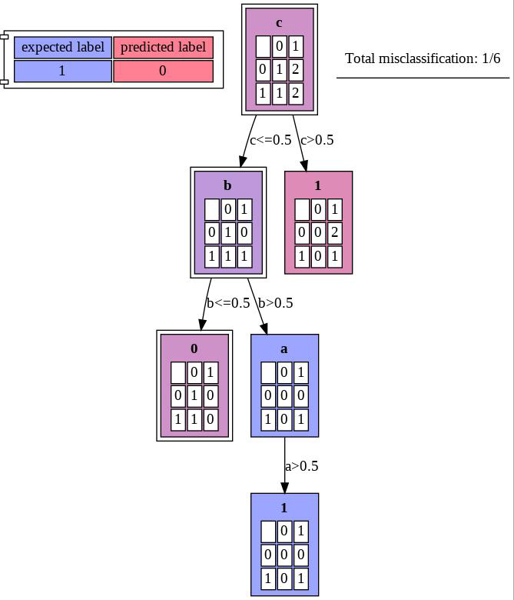

In [ ]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label = 1, predicted_label = 0,
                                   expected_label_color = '#9ca5ff', predicted_label_color = '#ff8093',
                                   show_cm = True, present = 'visited', max_depth = None)
plot

Setting it to `misclassified` will present only nodes that are relevant to the misclassification:

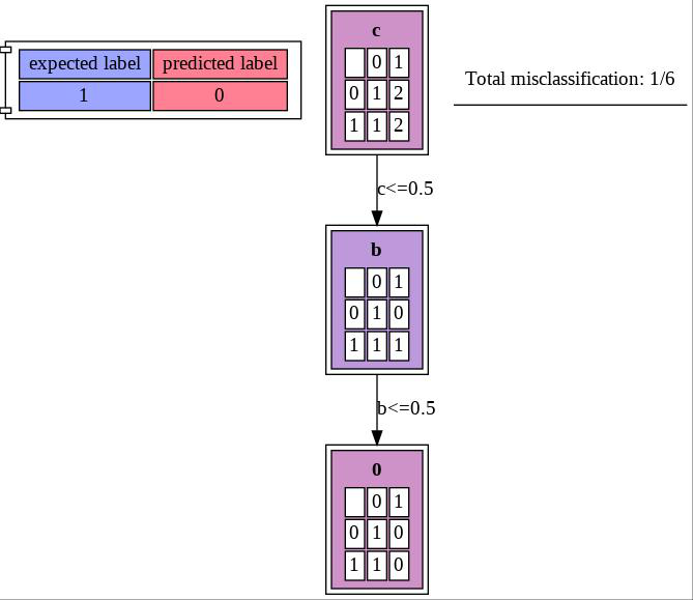

In [ ]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label = 1, predicted_label = 0, 
                                   expected_label_color = '#9ca5ff', predicted_label_color = '#ff8093',
                                   show_cm = True, present = 'misclassified', max_depth = None)
plot

`present` default value is `all` as illustrated in the first plot.

### The `show_cm` Attribute

This attribute enables to display (or not to display) the confusion matrix in every node. Its default value is `True` but we can change it to `false`:

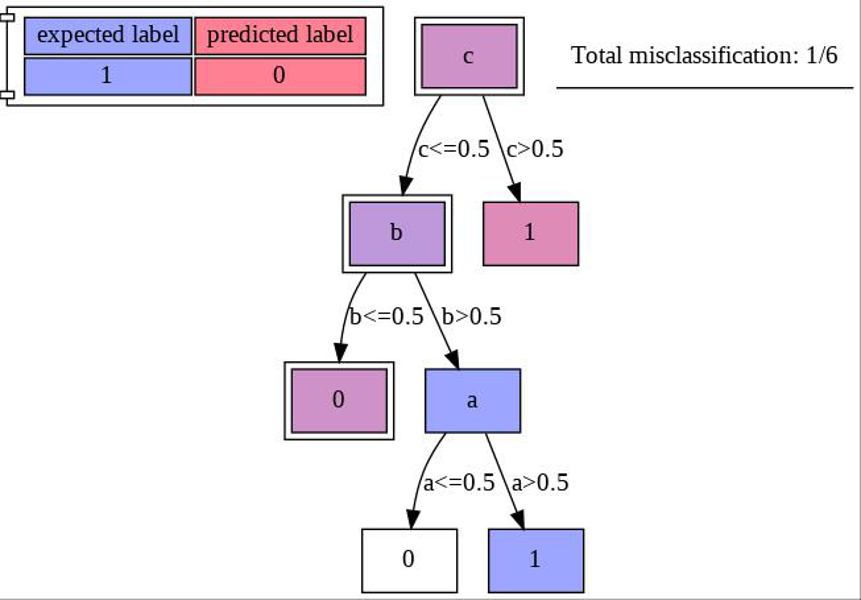

In [ ]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label = 1, predicted_label = 0, 
                                   expected_label_color = '#9ca5ff', predicted_label_color = '#ff8093',
                                   show_cm = False, present = 'all', max_depth = None)
plot

This is useful for cases in which we want to focus only on the flow of the data in the tree.

### The `max_depth` Attribute

Decision tree use a greedy approach to split a given plain into subplains, each consisting of as homogenous labeled-data as possible.

By limiting the maximal depth of the tree - one can limit the maximal plain splits.

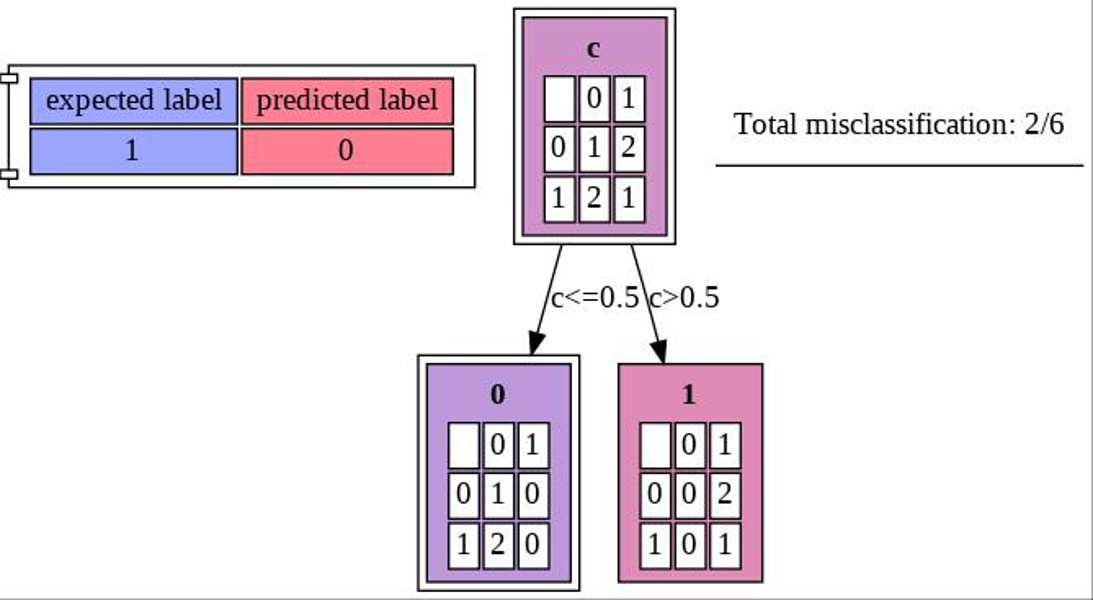

In [ ]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label = 1, predicted_label = 0, 
                                   expected_label_color = '#9ca5ff', predicted_label_color = '#ff8093',
                                   show_cm = True, present = 'all', max_depth = 1)
plot

*Note:* the default value of the `max_depth` attribute is `None`, which enables as much splits as possible of the data plain.

## Case B: 0 Misclassified as 1

We can repeat the same process to analyse cases in which 0 was misclassified as 1.

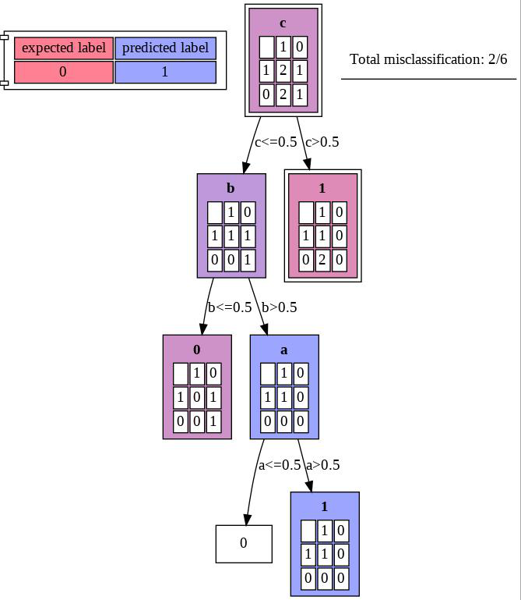

In [ ]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label = 0, predicted_label = 1, 
                                   expected_label_color = '#ff8093', predicted_label_color = '#9ca5ff',
                                   show_cm = True, present = 'all', max_depth = None)
plot

Here, setting the `present` to `misclassified` can illustrate the path in which the misclassified samples passed through more easily:

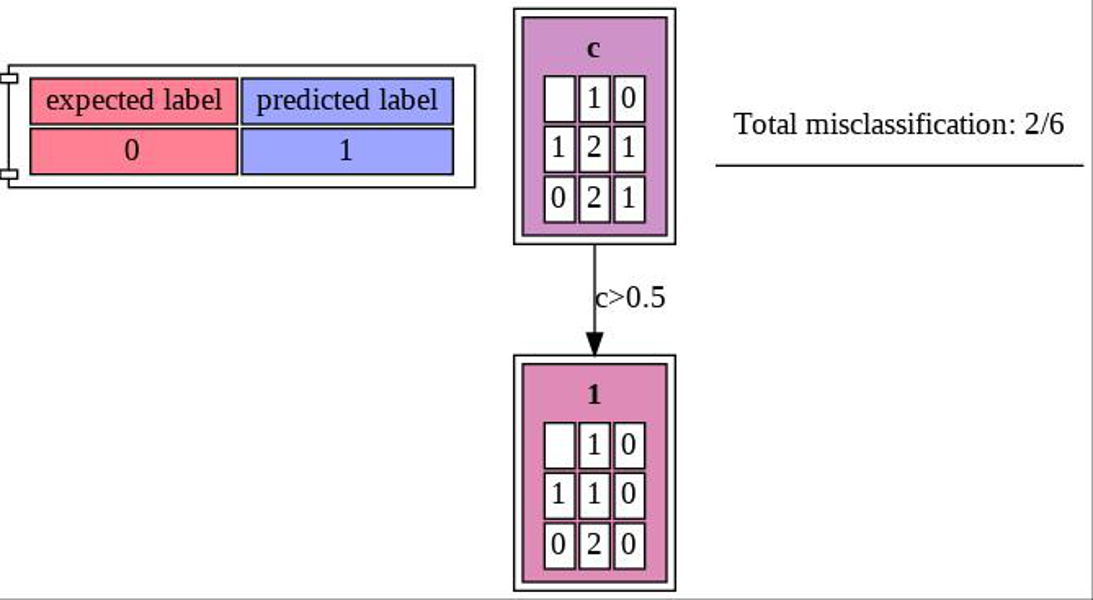

In [ ]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label = 0, predicted_label = 1, 
                                   expected_label_color = '#ff8093', predicted_label_color = '#9ca5ff',
                                   show_cm = True, present = 'misclassified', max_depth = None)
plot

## The Returned Values: `clf` and `plot`

As illustrated above, the plot_misclassification method returns two values:
* `clf` - the underlying representation of the decision tree. This is useful in case the datascientist wants to further investigate and examine the resulting tree.
* `plot` - an image of the plot.

# The `extract_decision_predicate_by_path` Function

As part of the MAGIC toolkit, I also provided the `extract_decision_predicate_by_path` function. this function gets a tree classifier and a test-set, and extracts for each of the samples the relevant predicate according to their classification path along the tree.


In [ ]:
predicate = extract_decision_predicate_by_path(clf, pd.DataFrame([[1,1,0]], columns = ['a','b','c']))

predicate

{0: "(x['c'] <= 0.5) & (x['b'] > 0.5) & (x['a'] > 0.5)"}

As we can see, the *c* value of the sample with index 0 is less then 0.5 and its *b* and *a* values are bigger then 0.5. That was the path the sample made along the MAGIC tool's tree.

If we use the test-set in extract_decision_predicate_by_path we will get:

In [ ]:
test_set_predicates = extract_decision_predicate_by_path(clf, X_test)

test_set_predicates

{0: "(x['c'] <= 0.5) & (x['b'] > 0.5) & (x['a'] > 0.5)",
 1: "(x['c'] > 0.5)",
 2: "(x['c'] > 0.5)",
 3: "(x['c'] <= 0.5) & (x['b'] <= 0.5)",
 4: "(x['c'] > 0.5)",
 5: "(x['c'] <= 0.5) & (x['b'] <= 0.5)"}

Here, samples 1, 2 and 4 share the same path along the tree. let's take a look at them:

In [ ]:
X_test.iloc[[1,2,4]]

,a,b,c
1,1,0,1
2,1,1,1
4,0,1,1


Last, we can use lambda function with the relevant predicate to fetch all the samples that were classified in the same manner as a given sample. For example, for sample 1:

In [ ]:
predicate_func = eval('lambda x: ' + test_set_predicates[1])

X_test[predicate_func]

,a,b,c
1,1,0,1
2,1,1,1
4,0,1,1


And for sample 3:

In [ ]:
predicate_func = eval('lambda x: ' + test_set_predicates[3])

X_test[predicate_func]

,a,b,c
3,0,0,0
5,1,0,0


# Brief Real World Example

To illustrate how the MAGIC tool works for real-world examples, I'll use the [Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

df = pd.read_csv("/content/drive/MyDrive/שנה א' - סמסטר א'/מדעי נתונים טבלאיים/מחברות לפרוייקט/healthcare-dataset-stroke-data.csv")

I will first clean the data: 
* Remove one sample with unique gender value - *Other*.
* Remove irrelevant *id* attribute.
* Use one-hot encoded values for categorial attributes: gender, ever_married, Residence_type, work_type and smoking_status.
* Fill missing values of bmi with the mean value.

In [ ]:
# Remove one sample with gender value of *Other*
df.drop(df[df['gender']=='Other'].index, inplace=True)

# Remove irrelevant id attribute.
df.drop(["id"], axis=1, inplace = True)

# Use one-hot encoded values for categorial attributes
df['gender'] = df['gender'].replace({'Male':0, 'Female':1})
df['ever_married'] = df['ever_married'].replace({'No':0, 'Yes':1})
df["Residence_type"] = df['Residence_type'].replace({'Rural':0, 'Urban':1})

work_type_dummies = pd.get_dummies(df['work_type'],drop_first=False)
smoking_status_dummies = pd.get_dummies(df['smoking_status'],drop_first=False)
df = pd.concat([df, work_type_dummies, smoking_status_dummies],axis=1)
df.drop(["smoking_status", "work_type"], axis=1, inplace = True)

# Fill missing values of bmi with the mean value
df['bmi'].fillna(value=df['bmi'].mean(), inplace=True)

df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Govt_job,Never_worked,Private,Self-employed,children,Unknown,formerly smoked,never smoked,smokes
0,0,67.0,0,1,1,1,228.69,36.60000,1,0,0,1,0,0,0,1,0,0
1,1,61.0,0,0,1,0,202.21,28.89456,1,0,0,0,1,0,0,0,1,0
2,0,80.0,0,1,1,0,105.92,32.50000,1,0,0,1,0,0,0,0,1,0
3,1,49.0,0,0,1,1,171.23,34.40000,1,0,0,1,0,0,0,0,0,1
4,1,79.0,1,0,1,0,174.12,24.00000,1,0,0,0,1,0,0,0,1,0


As the data is not balances and contains only 249 patients who had strokes and 4860 that didn't, I will randomally choose 200 samples from each group.

In [ ]:
print("The target class distribution is:")
print(df['stroke'].value_counts())
print()

shuffled_df = df.sample(frac=1, random_state=42)
df1 = pd.concat([shuffled_df[shuffled_df['stroke'] == 0][:200], shuffled_df[shuffled_df['stroke'] == 1][:200]])
print("The target class distribution in the updated dataset is:")
print(df1['stroke'].value_counts())

The target class distribution is:
0    4860
1     249
Name: stroke, dtype: int64

The target class distribution in the updated dataset is:
0    200
1    200
Name: stroke, dtype: int64


Now, we can split the data to train and test and use the MAGIC tool.

In [ ]:
X = df1.drop(['stroke'],axis=1)
y = df1['stroke']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

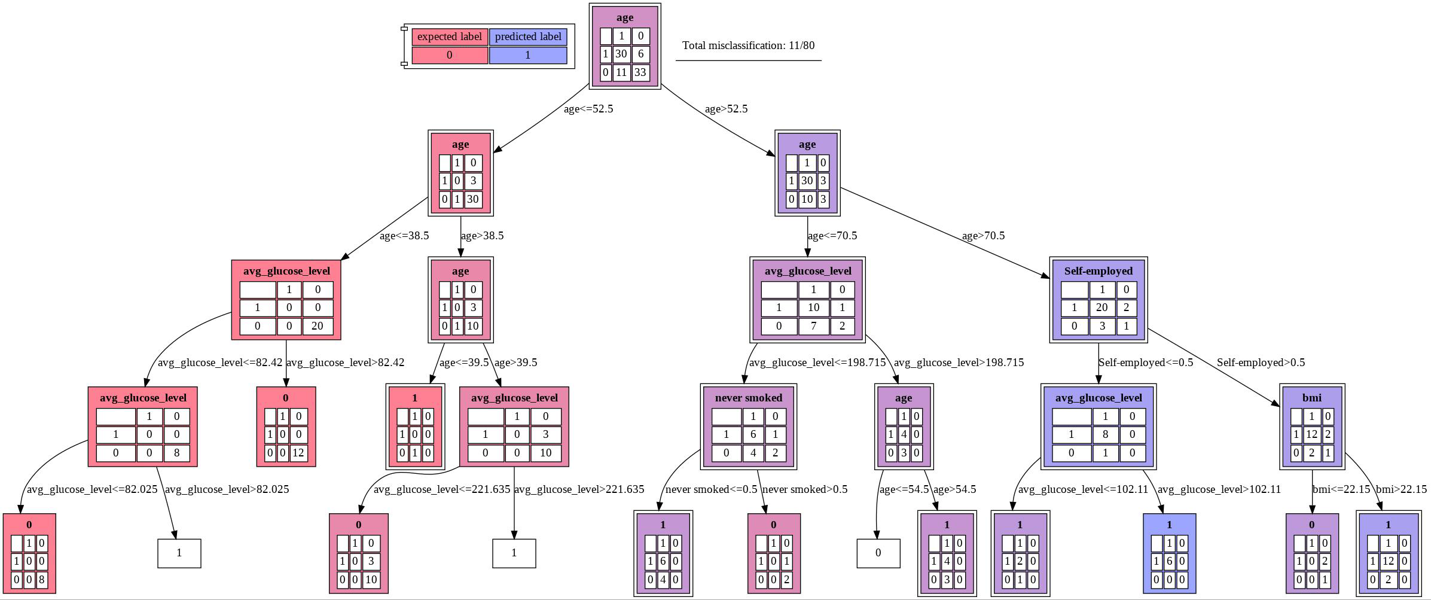

In [ ]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label = 0, predicted_label = 1, expected_label_color = '#ff8093', predicted_label_color = '#9ca5ff',
                                   show_cm = True, present = 'all', max_depth = 4)
plot

# Conclusion

The MAGIC tool is a vast tool as it enables the data-scientist to choose and present different views of the data after splitting it to subplains.

It also contains the `extract_decision_predicate_by_path` function that assists in extracting samples' predicate from the MAGIC tool to further analyse them.

<hr>

#Appendix: Illustrations For The Questionnaire

I used the above Stroke dataset example in the instructions of the questionnaire. 

As its sole purpose is demonstration, I "tweaked" it a bit to make the visual part more clear.

## The MAGIC Tool Illustraion


I used a tree with depth 3 for the MAGIC tool demonstration:

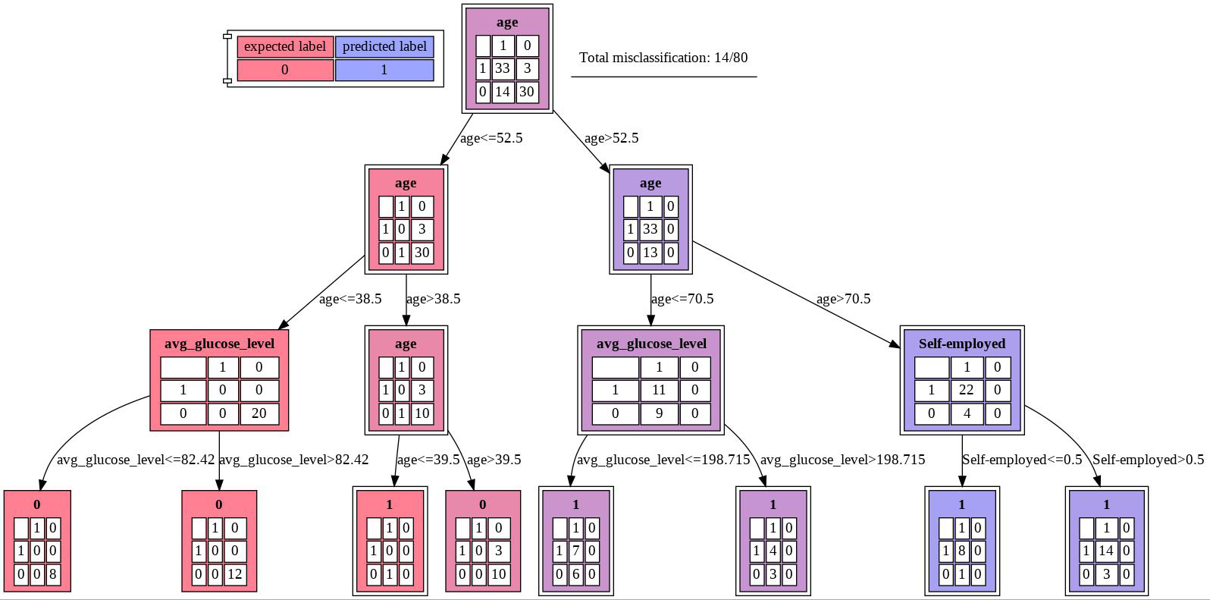

In [ ]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label = 0, predicted_label = 1, expected_label_color = '#ff8093', predicted_label_color = '#9ca5ff',
                                   show_cm = True, present = 'all', max_depth = 3)
plot

## The Scatter Plot Illustration

For the Scatter plot, I randomally chose to use the KNN classifier:

### 1. Create KNN Classifier With Best Performance

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters = {
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'n_neighbors': [3,5,7,9],    
              'weights' : ['uniform', 'distance']              
             }
knn11 = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
knn11.fit(X_train, y_train)

knn = KNeighborsClassifier(algorithm = knn11.best_params_['algorithm'],
                           n_neighbors =  knn11.best_params_['n_neighbors'],
                           weights = knn11.best_params_['weights'])

knn.fit(X_train, y_train);

## 2. Plot The Classifier's Misclassification Using a Scatter Plot

In [ ]:
predicions = knn.predict(X_test)
misclassification_index = [i for i in range(len(X_test)) if predicions[i] == 1 and y_test.iloc[i] == 0]

In [ ]:
df1 = pd.concat([X, y], axis = 1) # I used X and y to enhance the visualization
misclassified_samples = X_test.iloc[misclassification_index].copy(deep = True)
misclassified_samples['stroke'] = '0 misclassified as 1'

df1 = pd.concat([df1, misclassified_samples], axis = 0)

For the final Scatter plot I randomally chose the *age* and *avg_glucose_level* attributes:

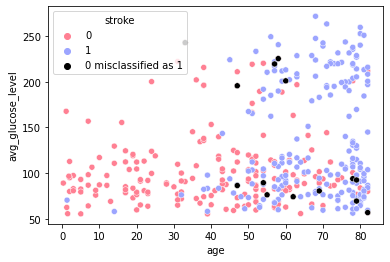

In [ ]:
sns.scatterplot(data = df1[['age', 'avg_glucose_level', 'stroke']], x = 'age', y = 'avg_glucose_level', hue="stroke", palette = {0: '#ff8093', 1: '#9ca5ff', '0 misclassified as 1': 'black'})